In [1]:
import json
import os

import pandas as pd
import numpy as np

def read_json_to_df(file_name):
    data = []
    with open(file_name) as data_file:
        for line in data_file:
            # Load each line of the JSON file as a dictionary
            data.append(json.loads(line))

    # Form a Pandas DataFrame from the dictionaries
    return pd.json_normalize(data)

# Load the training and test data
raw_train_df = read_json_to_df("hotel_reviews_train.json")
raw_test_df = read_json_to_df("hotel_reviews_test.json")

ratings_columns = [col for col in raw_train_df.columns if col.startswith("ratings.")]

# Select the title, text and overall rating columns to make a new dataframe
train_df = raw_train_df[["title", "text"] + ratings_columns]
test_df = raw_test_df[["title", "text"] + ratings_columns]

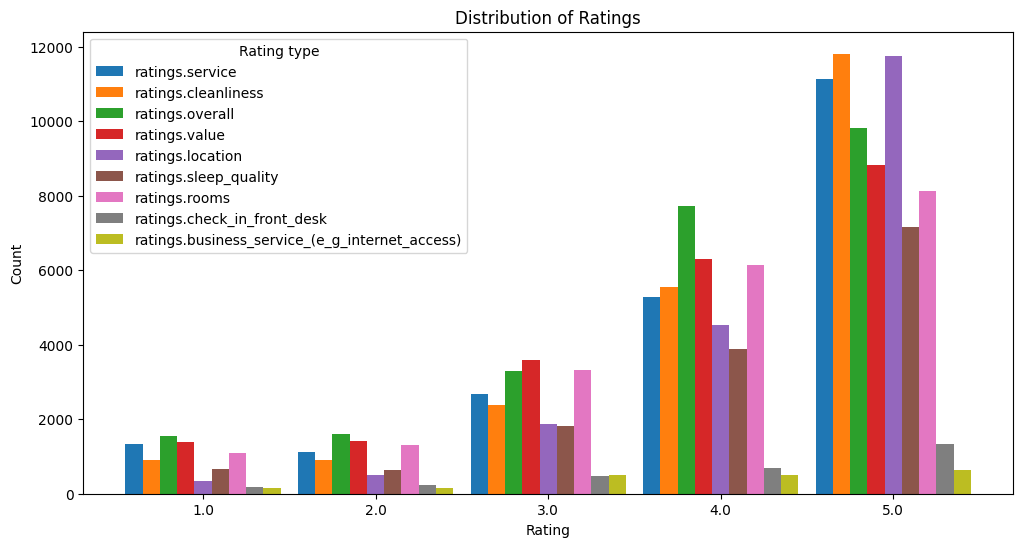

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

rating_counts = pd.DataFrame({
    col: train_df[col].value_counts().sort_index() for col in ratings_columns
})

bar_width = 0.15
group_spacing = 1.5
indices = np.arange(len(rating_counts)) * group_spacing

for i, column in enumerate(rating_counts.columns):
    plt.bar(indices + i * bar_width, rating_counts[column], width=bar_width, label=column)

plt.xticks(indices + bar_width * (len(ratings_columns) - 1) / 2, rating_counts.index)

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.legend(title="Rating type")
plt.show()

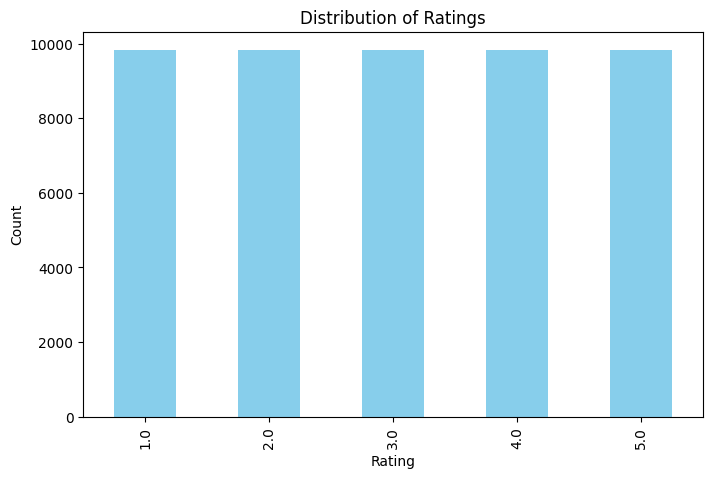

In [3]:
# Balance the training data by oversampling
def balance_data_oversample(df):
    max_count = df['ratings.overall'].value_counts().max()
    balanced_df = pd.DataFrame()

    for rating in df['ratings.overall'].unique():
        rating_df = df[df['ratings.overall'] == rating]
        balanced_df = pd.concat([balanced_df, rating_df.sample(max_count, replace=True)])

    return balanced_df
balanced_train_df = balance_data_oversample(train_df)

# Plot distribution of ratings
balanced_train_df['ratings.overall'].value_counts().sort_index().plot(kind='bar', figsize=(8,5), color='skyblue')

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

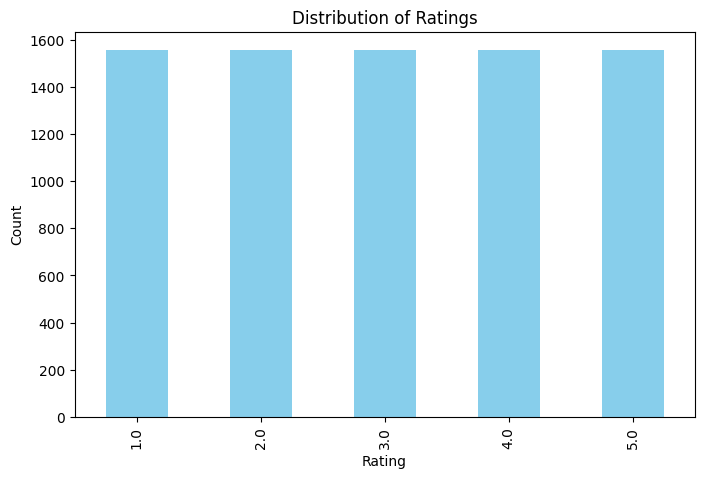

In [4]:
# Balance the training data by undersampling
def balance_data_undersample(df):
    min_count = df['ratings.overall'].value_counts().min()
    balanced_df = pd.DataFrame()

    for rating in df['ratings.overall'].unique():
        rating_df = df[df['ratings.overall'] == rating]
        balanced_df = pd.concat([balanced_df, rating_df.sample(min_count, replace=False)])

    return balanced_df

balanced_train_df = balance_data_undersample(train_df)

# Plot distribution of ratings
balanced_train_df['ratings.overall'].value_counts().sort_index().plot(kind='bar', figsize=(8,5), color='skyblue')

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

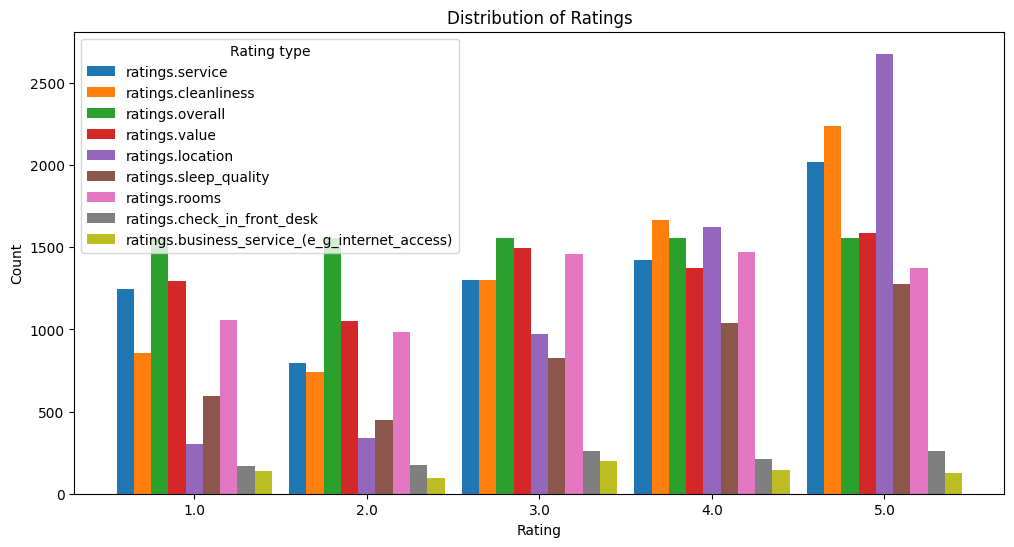

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

rating_counts = pd.DataFrame({
    col: balanced_train_df[col].value_counts().sort_index() for col in ratings_columns
})

bar_width = 0.15
group_spacing = 1.5
indices = np.arange(len(rating_counts)) * group_spacing

for i, column in enumerate(rating_counts.columns):
    plt.bar(indices + i * bar_width, rating_counts[column], width=bar_width, label=column)

plt.xticks(indices + bar_width * (len(ratings_columns) - 1) / 2, rating_counts.index)

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.legend(title="Rating type")
plt.show()

In [6]:
len(balanced_train_df['text'][0].split(' '))

199

In [7]:
average_sequence_length = balanced_train_df['text'].apply(lambda text: text.split(' ')).apply(len).mean()

In [8]:
balanced_train_df = balanced_train_df.fillna(0)
test_df = test_df.fillna(0)

In [9]:
inputs = balanced_train_df[ratings_columns]
outputs = balanced_train_df['text']

inputs_test = test_df[ratings_columns]
outputs_test = test_df['text']

In [10]:
def format_input(rating) -> str:
    input = "Generate a hotel review based on the following ratings:\n"
    service = rating.iloc[0]
    cleanliness = rating.iloc[1]
    overall = rating.iloc[2]
    value = rating.iloc[3]
    location = rating.iloc[4]
    sleep_quality = rating.iloc[5]
    rooms = rating.iloc[6]
    check_in_front_desk = rating.iloc[7]
    business_service = rating.iloc[8]

    if service:
      input += f"- service: {service}\n"
    if cleanliness:
      input += f"- cleanliness: {cleanliness}\n"
    if overall:
      input += f"- overall: {overall}\n"
    if value:
      input += f"- value: {value}\n"
    if location:
      input += f"- location: {location}\n"
    if sleep_quality:
      input += f"- sleep quality: {sleep_quality}\n"
    if rooms:
      input += f"- rooms: {rooms}\n"
    if check_in_front_desk:
      input += f"- check in: {check_in_front_desk}\n"
    if business_service:
      input += f"- business service: {business_service}\n"

    return input

In [11]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments

from datasets import Dataset

from math import ceil

dataset = Dataset.from_dict({"ratings": inputs.apply(format_input, axis=1).to_list(), "review_text": outputs.to_list()})

dataset = dataset.shuffle()

# Preprocessing function for dataset
def preprocess(tokeniser, examples):
    model_inputs = tokeniser(examples["ratings"], truncation=True, padding="max_length", max_length=30)
    labels = tokeniser(examples["review_text"], truncation=True, padding="max_length", max_length=ceil(average_sequence_length))
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

2025-05-28 09:26:48.052926: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 09:26:48.061952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748390208.073440   18796 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748390208.076774   18796 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748390208.085494   18796 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [12]:
tokeniser = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

tokenized = dataset.map(lambda batch: preprocess(tokeniser, batch), batched=True)
training_args = TrainingArguments(output_dir='./results', per_device_train_batch_size=8, num_train_epochs=10)

trainer = Trainer(model=model, args=training_args, train_dataset=tokenized)
trainer.train()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/7785 [00:00<?, ? examples/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
500,3.474900
1000,3.182400
1500,3.130800
2000,3.142300
2500,3.099600
3000,3.088200
3500,3.084300
4000,3.051200
4500,3.056700
5000,3.065500


TrainOutput(global_step=9740, training_loss=3.0797839530929156, metrics={'train_runtime': 1514.4102, 'train_samples_per_second': 51.406, 'train_steps_per_second': 6.432, 'total_flos': 617364799488000.0, 'train_loss': 3.0797839530929156, 'epoch': 10.0})

In [15]:
def generate_review(ratings_str):
    device = model.device
    inputs = tokeniser(ratings_str, return_tensors="pt").to(device)
    output = model.generate(**inputs, max_length=average_sequence_length)
    return tokeniser.decode(output[0], skip_special_tokens=True)


test_dataset = Dataset.from_dict({"ratings": inputs_test.apply(format_input, axis=1).to_list(), "review_text": outputs_test.to_list()})


In [17]:
test_dataset = test_dataset.shuffle().select(range(100))  # Select 100 rows
from evaluate import load

from rouge import Rouge
from statistics import mean
rouge = Rouge()

generated_reviews = []
reference_reviews = []

for example in test_dataset:
    generated_review = generate_review(example["ratings"])

    generated_reviews.append(generated_review)
    reference_reviews.append(example["review_text"])

# Evaluate the summaries using the ROUGE metric
rouge_scores = rouge.get_scores(generated_reviews, reference_reviews)
rouge_1_ps = []
rouge_1_rs = []
rouge_1_fs = []

rouge_2_ps = []
rouge_2_rs = []
rouge_2_fs = []

rouge_l_ps = []
rouge_l_rs = []
rouge_l_fs = []
for score in rouge_scores:
    rouge_1_ps.append(score['rouge-1']['p'])
    rouge_1_rs.append(score['rouge-1']['r'])
    rouge_1_fs.append(score['rouge-1']['f'])

    rouge_2_ps.append(score['rouge-2']['p'])
    rouge_2_rs.append(score['rouge-2']['r'])
    rouge_2_fs.append(score['rouge-2']['f'])

    rouge_l_ps.append(score['rouge-l']['p'])
    rouge_l_rs.append(score['rouge-l']['r'])
    rouge_l_fs.append(score['rouge-l']['f'])

print(f"ROUGE-1 Precision: {mean(rouge_1_ps)}")
print(f"ROUGE-1 Recall: {mean(rouge_1_rs)}")
print(f"ROUGE-1 F1: {mean(rouge_1_fs)}")

print(f"ROUGE-2 Precision: {mean(rouge_2_ps)}")
print(f"ROUGE-2 Recall: {mean(rouge_2_rs)}")
print(f"ROUGE-2 F1: {mean(rouge_2_fs)}")

print(f"ROUGE-L Precision: {mean(rouge_l_ps)}")
print(f"ROUGE-L Recall: {mean(rouge_l_rs)}")
print(f"ROUGE-L F1: {mean(rouge_l_fs)}")

from statistics import mean
bertscore = load("bertscore")
results = bertscore.compute(predictions=generated_reviews, references=reference_reviews, lang="en")

precision = mean(results['precision'])
recall = mean(results['recall'])
f1_score = (2 * precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1_score:.4f}")

ROUGE-1 Precision: 0.3995423396696507
ROUGE-1 Recall: 0.1768891922850039
ROUGE-1 F1: 0.2178709638809651
ROUGE-2 Precision: 0.08903827448521573
ROUGE-2 Recall: 0.04993027001863745
ROUGE-2 F1: 0.053853860306301765
ROUGE-L Precision: 0.37696805365366776
ROUGE-L Recall: 0.16702440312170452
ROUGE-L F1: 0.20554189861078467


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.8400
Recall:    0.8253
F1 Score:  0.8326
